# Cell state x motif plot

Supp plot showing which motifs were extracted from each cell type (for the curated motif set).

Inputs:
1. Cluster config
2. One file per cell state with motif annotation and number of seqlets.

In [1]:
library(ggplot2)
library(dplyr)
library(scales)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Load inputs

In [2]:
NUM_CLUST = 15

### Cluster config

In [4]:
cluster_config = read.table("../../../figures_factory/configs/cluster.tsv", comment.char = '', header=T, sep='\t', stringsAsFactors = F)
cluster_config

cluster,colour,description,new_cluster
<int>,<chr>,<chr>,<int>
1,#B03743,Fibroblast,1
2,#E85F6D,Fibroblast-like,3
3,#7C2730,Fibroblast-like,2
4,#F0A118,Intermediate,12
5,#78A824,Pre-iPSC,13
6,#A6D854,Pre-iPSC,14
7,#F01D35,Fibroblast-like,5
8,#13C4A3,iPSC,15
9,#406614,Partially-reprogrammed,10


### Per cell state annotated MoDISco motifs

In [5]:
modisco_annotated = list()

for (i in seq(NUM_CLUST)) {
    modisco_annotated[[i]] = read.table(sprintf("../../../analysis/20230607_re_modisco_breakdown/manually_adjusted/cluster_idx%d.txt", i), 
                                        sep='\t', 
                                        header=T,
                                       stringsAsFactors=F)
    
}

head(modisco_annotated[[1]])

,Pattern,num_seqlets,match_1,q.value
,<chr>,<int>,<chr>,<dbl>
1,pattern_0,5944,CTCF,2.04043e-15
2,pattern_1,5056,AP1,1.53199e-09
3,pattern_2,1258,BHLH,4.55782e-08
4,pattern_3,1239,NFI,3.50974e-20
5,pattern_4,896,FOX,5.75062e-13
6,pattern_5,816,CREB,9.11878e-12


## Plot

Motifs with ":" are dimers of 30 curated motifs, which can be ignored for now.

Multiple patterns can match to the same motif.

In [7]:
QVAL = 0.05

In [25]:
motif_names = c()

for (i in seq(NUM_CLUST)) {
    motif_names = c(motif_names , modisco_annotated[[i]]$match_1)
}
motif_names = rev(sort(table(motif_names)))

In [26]:
motif_names

motif_names
    OCT-SOX         ETS          SP         AP1         KLF        CTCF 
         27          25          22          22          19          18 
        NRF        CREB        BHLH      ZNF143         RFX        REST 
         16          16          16          15          15          13 
        NFY         NFI        TEAD         OCT         SOX    AP1:TEAD 
         12          12          11          11          10          10 
    SOX:SOX         FOX       TFAP2        RUNX         SIX     KLF:KLF 
          9           9           8           7           6           6 
   CREB:ETS         COE        CEBP OCT-SOX:KLF        NFKB        MEF2 
          5           5           5           4           4           4 
  CREB:TEAD     AP1:ETS         ZIC         IRF     AP1:KLF   TEAD-TEAD 
          4           4           3           3           3           2 
  RUNX:TEAD     ETS:ETS    OCT:TEAD        GRHL         EGR     AP1:OCT 
          2           2           1    

In [27]:
non_dimer = names(motif_names)[!grepl(":", names(motif_names))]
non_dimer

[1] "OCT-SOX"   "ETS"       "SP"        "AP1"       "KLF"       "CTCF"     
 [7] "NRF"       "CREB"      "BHLH"      "ZNF143"    "RFX"       "REST"     
[13] "NFY"       "NFI"       "TEAD"      "OCT"       "SOX"       "FOX"      
[19] "TFAP2"     "RUNX"      "SIX"       "COE"       "CEBP"      "NFKB"     
[25] "MEF2"      "ZIC"       "IRF"       "TEAD-TEAD" "GRHL"      "EGR"

In [168]:
MOTIF_SUBSET = non_dimer
# MOTIF_SUBSET = names(motif_names)

In [169]:
filtered_modisco = list()

for (i in seq(NUM_CLUST)) {
    cur = modisco_annotated[[i]]
    cur = cur[cur$q.value < QVAL, ]
    cur$frac = cur$num_seqlets/sum(cur$num_seqlets)
    cur = cur[cur$match_1 %in% MOTIF_SUBSET, c("frac", "match_1")]
    cur = cur %>% group_by(match_1) %>% summarize_all(sum)
    cur$log10_frac = log10(cur$frac)
    
    filtered_modisco[[i]] = cur
}

In [170]:
plot_df = data.frame()

for (i in seq(NUM_CLUST)) {
    cur = filtered_modisco[[i]]
    cur$new_cluster = cluster_config[i, "new_cluster"]
    
    plot_df = rbind(plot_df, cur)
}

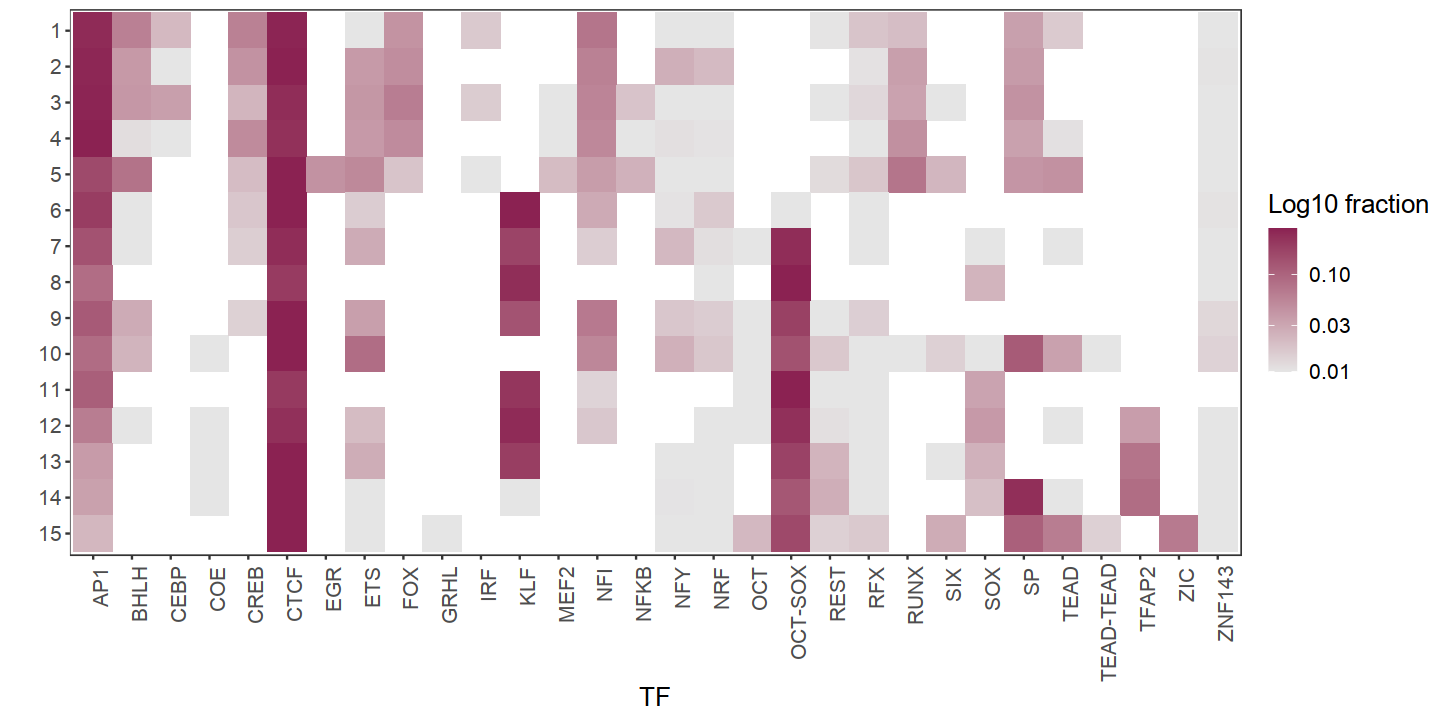

In [171]:
options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(plot_df) +
geom_tile(aes(x=match_1, y=factor(new_cluster, levels=rev(seq(NUM_CLUST))), fill=frac)) +
scale_fill_gradient(low="gray90",
                      high="violetred4",
                      limits=c(0.01, 0.3),
                      oob=squish,
                      trans='log10', 
                      name="Log10 fraction") +
xlab("TF") +
ylab("") +
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95), # rotate TF text
      strip.background = element_blank(),
      panel.grid.major = element_blank(),
          text = element_text(size=15)) 

Order for TFs based on similarity

In [172]:
head(plot_df)

match_1,frac,log10_frac,new_cluster
<chr>,<dbl>,<dbl>,<int>
AP1,0.266486695,-0.5743245,1
BHLH,0.060644042,-1.2172119,1
CEBP,0.021741226,-1.6627160,1
CREB,0.059583494,-1.2248740,1
CTCF,0.286540686,-0.5428137,1
ETS,0.008580794,-2.0664725,1


In [173]:
plot_df[i, ]$match_1

[1] "SP"

In [174]:
which(MOTIF_SUBSET == plot_df[i, "match_1"])

integer(0)

In [175]:
log10_matrix = matrix(1, length(MOTIF_SUBSET), NUM_CLUST)

log10_matrix = (min(plot_df$log10_frac) - 1)*log10_matrix

for (i in seq(nrow(plot_df))) {
    log10_matrix[which(MOTIF_SUBSET == plot_df[i, ]$match_1), plot_df[i,]$new_cluster] = plot_df[i,]$log10_frac
}

log10_matrix = t(log10_matrix)

In [210]:
tf_hclust = hclust(dist(t(scale(log10_matrix)), method = "euclidean"), method = "ward.D") # using scale to group by trend and not absolute values
tf_dendro = as.dendrogram(tf_hclust)
tf_dendro = reorder(tf_dendro, colSums(log10_matrix* seq(1,length(MOTIF_SUBSET)))/colSums(log10_matrix))
tf_order = as.hclust(tf_dendro)$order

In [211]:
tf_order

[1] 30 25 24 27 23 20 18  9 14  4  8  5  1 17 19 22 16 28 29 26  7 10 13  2 15
[26]  3 21 12 11  6

In [212]:
# bringing KLF and SP closer to each other as they are very similar motifs
# but assignment tends to be exclusive

In [213]:
tf_order = c(tf_order[1:12], tf_order[26], tf_order[13:25], tf_order[27:30])

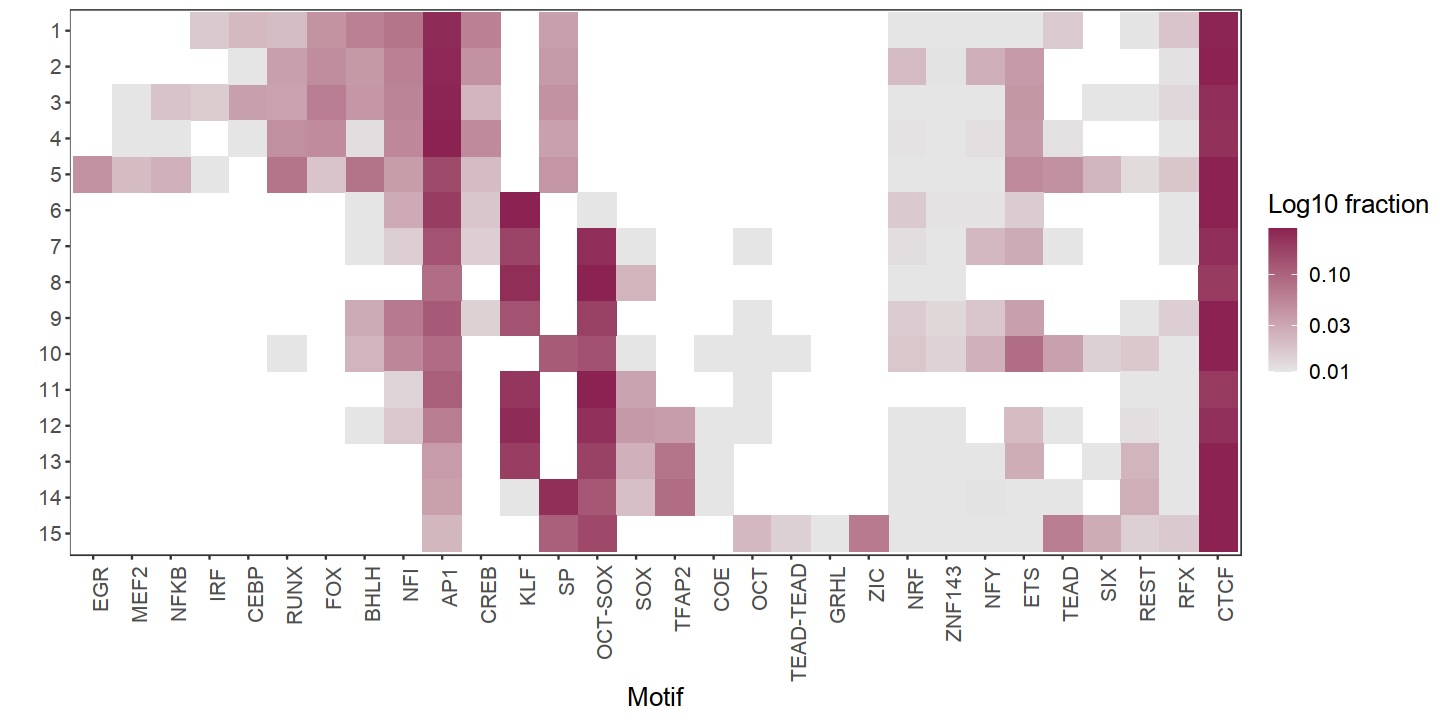

In [215]:
options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(plot_df) +
geom_tile(aes(x=factor(match_1, levels=MOTIF_SUBSET[tf_order]), y=factor(new_cluster, levels=rev(seq(NUM_CLUST))), fill=frac)) +
scale_fill_gradient(low="gray90",
                      high="violetred4",
                      limits=c(0.01, 0.3),
                      oob=squish,
                      trans='log10', 
                      name="Log10 fraction") +
xlab("Motif") +
ylab("") +
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95), # rotate TF text
      strip.background = element_blank(),
      panel.grid.major = element_blank(),
          text = element_text(size=15)) 

In [216]:
ggsave("./motif_x_cell_state.pdf", height=6, width=12, useDingbats=F)